In [30]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
from sklearn.metrics import (roc_auc_score, f1_score, roc_curve,
    average_precision_score,
    precision_recall_curve)
import util

In [2]:
train_results = pd.read_csv("train_preds.csv")
valid_results = pd.read_csv("valid_preds.csv")

# the labels in our dataset
class_labels = ['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

# the labels for prediction values in our dataset
pred_labels = [l + "_pred" for l in class_labels]

In [3]:
train_results.shape, valid_results.shape

((5000, 32), (1000, 31))

In [4]:
train_results.head()

,Unnamed: 0,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,...,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
0,28333,00008270_015.png,0,0,0,0,0,0,0,0,...,0.531233,0.077701,0.254761,0.071555,0.031860,0.125375,0.259928,0.171520,0.005386,0.079036
1,97164,00029855_001.png,1,0,0,0,1,0,0,0,...,0.530278,0.316036,0.403122,0.801598,0.793361,0.550383,0.497499,0.176103,0.359178,0.698990
2,4236,00001297_000.png,0,0,0,0,0,0,0,0,...,0.253458,0.394017,0.414019,0.426408,0.203794,0.625412,0.371834,0.693987,0.066478,0.258697
3,42962,00012359_002.png,0,0,0,0,0,0,0,0,...,0.261658,0.110398,0.133254,0.061813,0.072169,0.104288,0.160986,0.106231,0.088475,0.124298
4,63927,00017951_001.png,0,0,0,0,0,0,0,0,...,0.346267,0.060365,0.833480,0.045764,0.038951,0.794928,0.145725,0.697777,0.017091,0.192074


In [5]:
valid_results.head()

,Unnamed: 0,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,...,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
0,1685,00008522_004.png,0,0,0,0,0,0,0,0,...,0.256020,0.266928,0.312440,0.460342,0.079453,0.271495,0.276861,0.398799,0.015867,0.156320
1,1919,00009813_000.png,0,0,0,0,0,0,0,0,...,0.382199,0.176825,0.465807,0.489424,0.084595,0.377318,0.363582,0.638024,0.025948,0.144419
2,2048,00010344_000.png,0,0,0,0,0,0,0,0,...,0.427727,0.115513,0.249030,0.035105,0.238761,0.167095,0.166389,0.262463,0.007758,0.125790
3,21,00000242_003.png,0,0,0,0,0,0,0,0,...,0.158596,0.259460,0.334870,0.266489,0.073371,0.229834,0.191281,0.344348,0.008559,0.119153
4,503,00002529_016.png,0,0,0,0,0,0,0,0,...,0.536762,0.198797,0.273110,0.186771,0.242122,0.309786,0.411771,0.244666,0.126930,0.342409


In [6]:
train_results.drop(['Image', 'PatientId'], axis=1, inplace=True)
valid_results.drop(['Image', 'PatientId'], axis=1, inplace=True)

In [7]:
y = valid_results[class_labels].values
pred = valid_results[pred_labels].values

In [8]:
y.shape

(1000, 14)

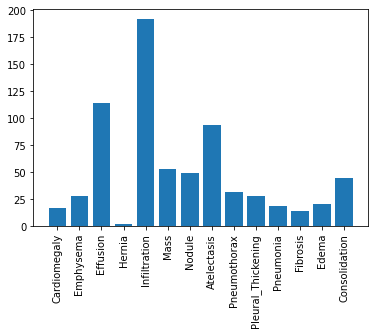

In [9]:
plt.xticks(rotation=90)
plt.bar(x = class_labels, height= y.sum(axis=0));

In [10]:
class EvaluationMatrix:
    def __init__(self, th=0.5):
        self.th = th
        
    def true_positives(self, y , pred): 
        above_threshold = (pred > self.th)
        return np.sum((y == 1) & (above_threshold == True))        
    
    def true_negatives(self, y , pred):       
        above_threshold = (pred > self.th)
        return np.sum((y == 0) &  (above_threshold == False))        
    
    def false_positives(self, y , pred):  
        above_threshold = (pred > self.th)
        return np.sum((y == 0) & (above_threshold == True))       
    
    def false_negatives(self, y , pred):
        above_threshold = (pred > self.th)
        return np.sum((y == 1) & (above_threshold == False))
    
    def performance_metrics(self, y, pred, class_labels, acc=None,thresholds=[]):
        if len(thresholds) != len(class_labels):
            thresholds = [self.th]*len(class_labels)
        columns = ["TP", "TN", "FP", "FN","AUC"]
        functions = [self.true_positives,
                    self.true_negatives,
                    self.false_positives,
                    self.false_negatives,
                    roc_auc_score]
        df = pd.DataFrame(columns=columns, index=class_labels)
        
        for i in range(len(class_labels)):
            for j, each in enumerate(columns):               
                df[each][i]=functions[j](y[:, i], pred[:,i]) 
        new_columns = ["Accuracy", "Prevalence", "Sensitivity", "Specificity", "PPV", "NPV",
              "F1", "Threshold"]
        df = pd.concat([df, pd.DataFrame(columns=new_columns)])
        df['Accuracy'] = df.apply(lambda x: (np.sum(x[0:2]))/np.sum(x[0:4]),axis=1)        
        df['Prevalence'] = df.apply(lambda x: (x['TP']+x['FN'])/np.sum(x[0:4]), axis=1)        
        df['Sensitivity'] = df.apply(lambda x: (x['TP']/(x['TP']+x['FN'])), axis=1)        
        df['Specificity'] = df.apply(lambda x: (x['TN']/(x['TN']+x['FP'])),axis=1)        
        df['PPV'] = df.apply(lambda x: (x['TP']/(x['TP']+x['FP'])), axis=1)
        df['NPV'] = df.apply(lambda x: (x['TN']/(x['TN']+x['FN'])),axis=1)
        df['F1'] = df.apply(lambda x : 2*(x['PPV']*x['Sensitivity'])/(x['PPV']+x['Sensitivity']), axis=1)
        df['Threshold'] = df.apply(lambda x: self.th, axis=1)
        return df

In [11]:
y = valid_results[class_labels].values
pred = valid_results[pred_labels].values
new_ev = EvaluationMatrix()

d = new_ev.performance_metrics(y, pred, class_labels)

In [12]:
d

,TP,TN,FP,FN,AUC,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,F1,Threshold
Cardiomegaly,16,814,169,1,0.932918,0.830,0.017,0.941176,0.828077,0.086486,0.998773,0.158416,0.5
Emphysema,20,869,103,8,0.935038,0.889,0.028,0.714286,0.894033,0.162602,0.990878,0.264901,0.5
Effusion,99,690,196,15,0.891331,0.789,0.114,0.868421,0.778781,0.335593,0.978723,0.484108,0.5
Hernia,1,743,255,1,0.644289,0.744,0.002,0.500000,0.744489,0.003906,0.998656,0.007752,0.5
Infiltration,114,543,265,78,0.695848,0.657,0.192,0.593750,0.672030,0.300792,0.874396,0.399299,0.5
Mass,40,789,158,13,0.887729,0.829,0.053,0.754717,0.833157,0.202020,0.983791,0.318725,0.5
Nodule,28,731,220,21,0.744823,0.759,0.049,0.571429,0.768665,0.112903,0.972074,0.188552,0.5
Atelectasis,64,657,249,30,0.781034,0.721,0.094,0.680851,0.725166,0.204473,0.956332,0.314496,0.5
Pneumothorax,24,785,183,8,0.826091,0.809,0.032,0.750000,0.810950,0.115942,0.989912,0.200837,0.5
Pleural_Thickening,24,713,259,4,0.868056,0.737,0.028,0.857143,0.733539,0.084806,0.994421,0.154341,0.5


In [13]:
new_columns = ["Accuracy", "Prevalence", "Sensitivity", "Specificity", "PPV", "NPV",
              "F1", "Threshold"]
d = pd.concat([d, pd.DataFrame(columns=new_columns)])

In [14]:
d

,TP,TN,FP,FN,AUC,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,F1,Threshold
Cardiomegaly,16,814,169,1,0.932918,0.830,0.017,0.941176,0.828077,0.086486,0.998773,0.158416,0.5
Emphysema,20,869,103,8,0.935038,0.889,0.028,0.714286,0.894033,0.162602,0.990878,0.264901,0.5
Effusion,99,690,196,15,0.891331,0.789,0.114,0.868421,0.778781,0.335593,0.978723,0.484108,0.5
Hernia,1,743,255,1,0.644289,0.744,0.002,0.500000,0.744489,0.003906,0.998656,0.007752,0.5
Infiltration,114,543,265,78,0.695848,0.657,0.192,0.593750,0.672030,0.300792,0.874396,0.399299,0.5
Mass,40,789,158,13,0.887729,0.829,0.053,0.754717,0.833157,0.202020,0.983791,0.318725,0.5
Nodule,28,731,220,21,0.744823,0.759,0.049,0.571429,0.768665,0.112903,0.972074,0.188552,0.5
Atelectasis,64,657,249,30,0.781034,0.721,0.094,0.680851,0.725166,0.204473,0.956332,0.314496,0.5
Pneumothorax,24,785,183,8,0.826091,0.809,0.032,0.750000,0.810950,0.115942,0.989912,0.200837,0.5
Pleural_Thickening,24,713,259,4,0.868056,0.737,0.028,0.857143,0.733539,0.084806,0.994421,0.154341,0.5


In [16]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, class_labels)

In [17]:
df_stat = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
for i in range(len(class_labels)):
    mean = statistics.mean(axis=1)[i]
    max_ = np.quantile(statistics, .95, axis=1)[i]
    min_ = np.quantile(statistics, .05, axis=1)[i]
    df_stat.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]

In [29]:
df_stat

,Mean AUC (CI 5%-95%)
Cardiomegaly,0.93 (0.89-0.96)
Emphysema,0.94 (0.91-0.96)
Effusion,0.89 (0.87-0.91)
Hernia,0.64 (0.30-0.98)
Infiltration,0.69 (0.66-0.72)
Mass,0.89 (0.85-0.93)
Nodule,0.75 (0.68-0.81)
Atelectasis,0.79 (0.74-0.82)
Pneumothorax,0.82 (0.76-0.89)
Pleural_Thickening,0.86 (0.81-0.91)


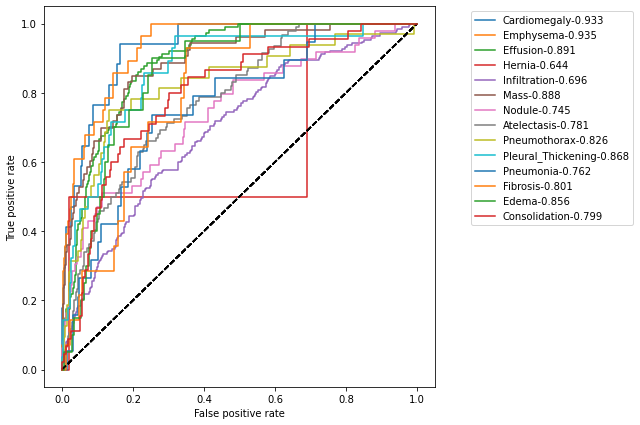

In [28]:
for i in range(len(class_labels)):    
    #curve_function = roc_curve
    auc_roc = d.loc[class_labels[i]]['AUC']    
    xlabel = "False positive rate"
    ylabel = "True positive rate"
    a, b, _ = roc_curve(y[:, i], pred[:, i])
    plt.figure(1, figsize=(7, 7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(a, b, label="{}-{:.3f}".format(class_labels[i], auc_roc))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

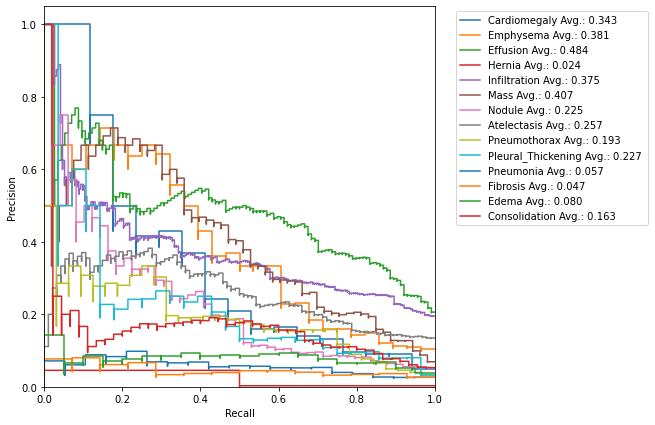

In [52]:
for i in range(len(class_labels)): 
    precision, recall, _ = precision_recall_curve(y[:, i], pred[:, i])
    
    average_precision = average_precision_score(y[:, i], pred[:, i])
    label = class_labels[i] + " Avg.: %.3f " % average_precision    
    plt.figure(1, figsize=(7, 7))
    plt.step(recall, precision, where='post', label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
            fancybox=True, ncol=1) 